In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
print(tf.__version__)

2.3.1


In [2]:
def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]

window_size = 20
batch_size = 32
shuffle_buffer_size = 1000

In [3]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[1:]))
    return ds.batch(batch_size).prefetch(1)

In [4]:
def model_forecast(model, series, window_size):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size))
    ds = ds.batch(32).prefetch(1)
    forecast = model.predict(ds)
    return forecast

In [5]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)

window_size = 30
train_set = windowed_dataset(x_train, window_size, batch_size=128, shuffle_buffer=shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=5,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, return_sequences=True)),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])
lr_schedule = tf.keras.callbacks.LearningRateScheduler(
    lambda epoch: 1e-8 * 10**(epoch / 20))
optimizer = tf.keras.optimizers.SGD(lr=1e-8, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(train_set, epochs=100, callbacks=[lr_schedule])

Epoch 1/100
8/8 [==============================] - 1s 105ms/step - loss: 73.1912 - mae: 73.6904
Epoch 2/100
8/8 [==============================] - 1s 79ms/step - loss: 72.4799 - mae: 72.9791
Epoch 3/100
8/8 [==============================] - 1s 83ms/step - loss: 71.3446 - mae: 71.8437
Epoch 4/100
8/8 [==============================] - 1s 86ms/step - loss: 69.9230 - mae: 70.4223
Epoch 5/100
8/8 [==============================] - 1s 85ms/step - loss: 68.2678 - mae: 68.7669
Epoch 6/100
8/8 [==============================] - 1s 78ms/step - loss: 66.3621 - mae: 66.8609
Epoch 7/100
8/8 [==============================] - 1s 74ms/step - loss: 64.2432 - mae: 64.7424
Epoch 8/100
8/8 [==============================] - 1s 81ms/step - loss: 61.8749 - mae: 62.3738
Epoch 9/100
8/8 [==============================] - 1s 81ms/step - loss: 59.2491 - mae: 59.7479
Epoch 10/100
8/8 [==============================] - 1s 76ms/step - loss: 56.3267 - mae: 56.8254
Epoch 11/100
8/8 [==============================

8/8 [==============================] - 1s 77ms/step - loss: 13.6610 - mae: 14.1543
Epoch 87/100
8/8 [==============================] - 1s 81ms/step - loss: 17.6728 - mae: 18.1685
Epoch 88/100
8/8 [==============================] - 1s 83ms/step - loss: 20.9873 - mae: 21.4830
Epoch 89/100
8/8 [==============================] - 1s 81ms/step - loss: 17.4590 - mae: 17.9532
Epoch 90/100
8/8 [==============================] - 1s 74ms/step - loss: 9.5987 - mae: 10.0889
Epoch 91/100
8/8 [==============================] - 1s 86ms/step - loss: 7.5716 - mae: 8.0580
Epoch 92/100
8/8 [==============================] - 1s 83ms/step - loss: 8.6463 - mae: 9.1361
Epoch 93/100
8/8 [==============================] - 1s 80ms/step - loss: 15.8557 - mae: 16.3503
Epoch 94/100
8/8 [==============================] - 1s 76ms/step - loss: 17.9272 - mae: 18.4223
Epoch 95/100
8/8 [==============================] - 1s 80ms/step - loss: 18.8747 - mae: 19.3705
Epoch 96/100
8/8 [==============================] - 1s 81m

(1e-08, 0.0001, 0.0, 30.0)

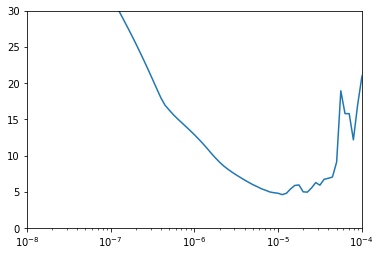

In [6]:
plt.semilogx(history.history["lr"], history.history["loss"])
plt.axis([1e-8, 1e-4, 0, 30])

In [ ]:
tf.keras.backend.clear_session()
tf.random.set_seed(51)
np.random.seed(51)
#batch_size = 16
dataset = windowed_dataset(x_train, window_size, batch_size, shuffle_buffer_size)

model = tf.keras.models.Sequential([
  tf.keras.layers.Conv1D(filters=32, kernel_size=3,
                      strides=1, padding="causal",
                      activation="relu",
                      input_shape=[None, 1]),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.LSTM(32, return_sequences=True),
  tf.keras.layers.Dense(1),
  tf.keras.layers.Lambda(lambda x: x * 200)
])

optimizer = tf.keras.optimizers.SGD(lr=1e-5, momentum=0.9)
model.compile(loss=tf.keras.losses.Huber(),
              optimizer=optimizer,
              metrics=["mae"])
history = model.fit(dataset,epochs=500)

Epoch 1/500
31/31 [==============================] - 4s 122ms/step - loss: 20.0714 - mae: 20.5646
Epoch 2/500
31/31 [==============================] - 4s 120ms/step - loss: 7.9198 - mae: 8.4048
Epoch 3/500
31/31 [==============================] - 3s 93ms/step - loss: 6.6716 - mae: 7.1533
Epoch 4/500
31/31 [==============================] - 3s 109ms/step - loss: 6.1672 - mae: 6.6477
Epoch 5/500
31/31 [==============================] - 3s 108ms/step - loss: 5.7151 - mae: 6.1947
Epoch 6/500
31/31 [==============================] - 2s 78ms/step - loss: 5.6474 - mae: 6.1274
Epoch 7/500
31/31 [==============================] - 2s 69ms/step - loss: 5.4905 - mae: 5.9700
Epoch 8/500
31/31 [==============================] - 2s 78ms/step - loss: 5.3463 - mae: 5.8258
Epoch 9/500
31/31 [==============================] - 2s 65ms/step - loss: 5.3880 - mae: 5.8676
Epoch 10/500
31/31 [==============================] - 3s 100ms/step - loss: 5.2159 - mae: 5.6951
Epoch 11/500
31/31 [======================

31/31 [==============================] - 3s 91ms/step - loss: 4.3143 - mae: 4.7893
Epoch 84/500
31/31 [==============================] - 3s 88ms/step - loss: 4.4307 - mae: 4.9067
Epoch 85/500
31/31 [==============================] - 3s 97ms/step - loss: 4.3776 - mae: 4.8540
Epoch 86/500
31/31 [==============================] - 2s 80ms/step - loss: 4.2680 - mae: 4.7427
Epoch 87/500
31/31 [==============================] - 3s 95ms/step - loss: 4.2931 - mae: 4.7685
Epoch 88/500
31/31 [==============================] - 2s 73ms/step - loss: 4.2196 - mae: 4.6936
Epoch 89/500
31/31 [==============================] - 3s 100ms/step - loss: 4.2215 - mae: 4.6961 0s - loss: 4.2159 - mae:
Epoch 90/500
31/31 [==============================] - 2s 79ms/step - loss: 4.2341 - mae: 4.7086
Epoch 91/500
31/31 [==============================] - 3s 98ms/step - loss: 4.2413 - mae: 4.7155
Epoch 92/500
31/31 [==============================] - 2s 62ms/step - loss: 4.2463 - mae: 4.7214
Epoch 93/500
31/31 [=======

31/31 [==============================] - 2s 78ms/step - loss: 4.1536 - mae: 4.6278
Epoch 166/500
31/31 [==============================] - 2s 70ms/step - loss: 4.1267 - mae: 4.6005
Epoch 167/500
31/31 [==============================] - 3s 89ms/step - loss: 4.1061 - mae: 4.5793
Epoch 168/500
31/31 [==============================] - 3s 81ms/step - loss: 4.1079 - mae: 4.5822
Epoch 169/500
31/31 [==============================] - 3s 94ms/step - loss: 4.1146 - mae: 4.5884: 0s - loss: 4.1325 - ma
Epoch 170/500
31/31 [==============================] - 2s 79ms/step - loss: 4.2529 - mae: 4.7275
Epoch 171/500
31/31 [==============================] - 3s 87ms/step - loss: 4.0993 - mae: 4.5724
Epoch 172/500
31/31 [==============================] - 3s 87ms/step - loss: 4.1443 - mae: 4.6181: 0s - loss: 4.1427 - mae: 4.61
Epoch 173/500
31/31 [==============================] - 3s 89ms/step - loss: 4.1118 - mae: 4.5849
Epoch 174/500
31/31 [==============================] - 2s 71ms/step - loss: 4.1143 - m

31/31 [==============================] - 2s 70ms/step - loss: 4.0588 - mae: 4.5319
Epoch 247/500
31/31 [==============================] - 3s 86ms/step - loss: 4.0542 - mae: 4.5273
Epoch 248/500
31/31 [==============================] - 2s 70ms/step - loss: 4.0417 - mae: 4.5143
Epoch 249/500
31/31 [==============================] - 3s 83ms/step - loss: 4.0454 - mae: 4.5179
Epoch 250/500
31/31 [==============================] - 2s 71ms/step - loss: 4.1035 - mae: 4.5773
Epoch 251/500
31/31 [==============================] - 3s 84ms/step - loss: 4.0941 - mae: 4.5677
Epoch 252/500
31/31 [==============================] - 2s 67ms/step - loss: 4.0440 - mae: 4.5167
Epoch 253/500
31/31 [==============================] - 3s 83ms/step - loss: 4.0392 - mae: 4.5119
Epoch 254/500
31/31 [==============================] - 2s 72ms/step - loss: 4.0341 - mae: 4.5070
Epoch 255/500
31/31 [==============================] - 2s 62ms/step - loss: 4.1261 - mae: 4.6004
Epoch 256/500
31/31 [=======================

31/31 [==============================] - 2s 71ms/step - loss: 4.0269 - mae: 4.5002
Epoch 329/500
31/31 [==============================] - 3s 84ms/step - loss: 4.0485 - mae: 4.5217
Epoch 330/500
31/31 [==============================] - 2s 75ms/step - loss: 3.9756 - mae: 4.4485
Epoch 331/500
31/31 [==============================] - 3s 82ms/step - loss: 3.9652 - mae: 4.4379
Epoch 332/500
31/31 [==============================] - 2s 75ms/step - loss: 3.9810 - mae: 4.4536
Epoch 333/500
31/31 [==============================] - 3s 85ms/step - loss: 3.9775 - mae: 4.4498
Epoch 334/500
31/31 [==============================] - 2s 72ms/step - loss: 3.9814 - mae: 4.4526
Epoch 335/500
31/31 [==============================] - 3s 81ms/step - loss: 4.0890 - mae: 4.5630
Epoch 336/500
31/31 [==============================] - 2s 76ms/step - loss: 4.0190 - mae: 4.4919: 0s - loss: 4.0190 - mae: 4.491
Epoch 337/500
31/31 [==============================] - 2s 72ms/step - loss: 4.0612 - mae: 4.5351
Epoch 338/50

31/31 [==============================] - 2s 72ms/step - loss: 4.0605 - mae: 4.5347
Epoch 411/500
31/31 [==============================] - 3s 83ms/step - loss: 3.9319 - mae: 4.4037
Epoch 412/500
31/31 [==============================] - 2s 70ms/step - loss: 3.9387 - mae: 4.4116
Epoch 413/500
31/31 [==============================] - 3s 81ms/step - loss: 3.9423 - mae: 4.4138
Epoch 414/500
31/31 [==============================] - 2s 64ms/step - loss: 3.9589 - mae: 4.4307
Epoch 415/500
31/31 [==============================] - 3s 81ms/step - loss: 3.9424 - mae: 4.4142
Epoch 416/500
31/31 [==============================] - 2s 72ms/step - loss: 3.9463 - mae: 4.4184
Epoch 417/500
31/31 [==============================] - 2s 65ms/step - loss: 4.0380 - mae: 4.5115
Epoch 418/500
31/31 [==============================] - 2s 63ms/step - loss: 4.0113 - mae: 4.4842
Epoch 419/500
31/31 [==============================] - 2s 62ms/step - loss: 3.9426 - mae: 4.4151
Epoch 420/500
31/31 [=======================

In [ ]:
rnn_forecast = model_forecast(model, series[..., np.newaxis], window_size)
rnn_forecast = rnn_forecast[split_time - window_size:-1, -1, 0]

In [ ]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, rnn_forecast)

In [ ]:
tf.keras.metrics.mean_absolute_error(x_valid, rnn_forecast).numpy()

In [ ]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

#-----------------------------------------------------------
# Retrieve a list of list results on training and test data
# sets for each training epoch
#-----------------------------------------------------------
mae=history.history['mae']
loss=history.history['loss']

epochs=range(len(loss)) # Get number of epochs

#------------------------------------------------
# Plot MAE and Loss
#------------------------------------------------
plt.plot(epochs, mae, 'r')
plt.plot(epochs, loss, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()

epochs_zoom = epochs[200:]
mae_zoom = mae[200:]
loss_zoom = loss[200:]

#------------------------------------------------
# Plot Zoomed MAE and Loss
#------------------------------------------------
plt.plot(epochs_zoom, mae_zoom, 'r')
plt.plot(epochs_zoom, loss_zoom, 'b')
plt.title('MAE and Loss')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend(["MAE", "Loss"])

plt.figure()